# Relation Extraction - SemEval 2010

---

Task 8

Group members:<br/>
Mohammed Mehdi Patel - y28520mp<br/>
Antas Singh - v06383as<br/>
Nilakhi Das - b02373nd<br/>
Ayush Garg - c81114ag<br/>

<br>

This file contains the code for our second approach.The model used incorporates an attention mechanism alongside bidirectional Long Short-Term Memory (LSTM) layer , this model is trained on features generated using NLP techniques.

If you want to test our model by providing some inputs, you can directly go to the last 4 cells of this notebook. Instructions on how to provide inputs is provided in those cells. Make sure you install all the required packages with the first line of this notebook.<br/>
**Note: The 4th last cell of this notebook mounts google drive since this notebook was prepared in google colab. You would not need to run this cell if you are not using google colab.**

<br/>
The notebook starts with an install statement of libraries that will be required to run this notebook and then what follows is our code to preprocess the data, create features and train and evaluate the model.

<br/>


## Code Attributions and Enhancements:<br/>
We got some idea of preprocessing the data files from  [Sahitya's repository on Github](https://github.com/sahitya0000/Relation-Classification/tree/master)
.After preprocessing the data files and converting them to pandas dataframes, we used various NLP techniques to make features which will be used to train the model . One of the data preprocessing method and basic idea for bi-LSTM came from [Valette, Marion (2019). Simple Relation Extraction with a Bi-LSTM Model.](https://medium.com/southpigalle/simple-relation-extraction-with-a-bi-lstm-model-part-1-682b670d5e11). After learning from this article we have modified the model and added multiple new layers and attention mechanisms to increase the performance significantly. As mentioned in Valette, Marion article we have used word indices approach for one of the features in our model, in addition to that we have used techniques like relative positioning, PoS tagging , pretrained word vectors and many more changes which helped us achieve better performance.




Following is a summary our implementation:
1.  Transformed our sentences into word indices. Each word has a unique index in the vocabulary constructed from the train set.
2. The relative position of each word in the sentence with respect to each entity(e1 and e2) is calculated from the absolute positions indicated in the dataset and then normalizing these values
3. Part of speech tagging is made for every sentence. Use spacy to find out POS tags
4. Initializing an embedding layer in Keras using pre-trained word vectors from SpaCy, which are then used to construct an embedding matrix for the embedding layer.
5. Using the following features to train the model with padding:
<ul>
<li>word indices</li>
<li>relative position with respect to e1</li>
<li>relative position with respect to e2</li>
<li>pos tagging for each sentence</li>
</ul>
6. We made a model with multiple layers, first, we make a masking layer that will mask all the 0 in the input. This is applied to all 4 input features.
7. We are using keras to build our model, and using keras we added a bi-LSTM layer, then output from this layer is given as input to a custom attention layer, and then a dense layer is used to generate output.
8. We trained the above model with the described features and then tested the trained model on testing data.



In [21]:
#if you get any error related to en_core_web_sm it may be related to you python version.
#you can then try replacing 'python3' with 'python' and 'pip3' with 'pip'.

!pip3 install gensim numpy pandas spacy scikit-learn joblib seaborn matplotlib tensorflow nltk keras
!python -m spacy download en_core_web_md

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 MB 25.2 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [4]:
import spacy
import pandas as pd

In [5]:
nlp = spacy.load("en_core_web_md")

In [6]:
# Please uncomment and run this if using googlw colab
# from google.colab import drive
# drive.mount('/gdrive')
# %cd /gdrive
# %cd MyDrive/TextMining/SemEval2010_task8_all_data/
# !ls

Mounted at /gdrive
/gdrive
/gdrive/MyDrive/TextMining/SemEval2010_task8_all_data
my_model.h5		       SemEval2010_task8_testing_keys
my_model.keras		       SemEval2010_task8_training
SemEval2010_task8_scorer-v1.2  SEMEVAL_TASK8_FULL_RELEASE_README.txt
SemEval2010_task8_testing      tokenizer.kv


In [7]:
lines = [line.strip() for line in open('SemEval2010_task8_training/TRAIN_FILE.TXT')]
for line in lines[:11]:
  print(line)

1	"The system as described above has its greatest application in an arrayed <e1>configuration</e1> of antenna <e2>elements</e2>."
Component-Whole(e2,e1)
Comment: Not a collection: there is structure here, organisation.

2	"The <e1>child</e1> was carefully wrapped and bound into the <e2>cradle</e2> by means of a cord."
Other
Comment:

3	"The <e1>author</e1> of a keygen uses a <e2>disassembler</e2> to look at the raw assembly code."
Instrument-Agency(e2,e1)
Comment:


# Creating train and test dataframes

In [8]:
records = []
for i in range(0, len(lines), 4):

  sentence_num, sentence = lines[i].split("\t")[0], lines[i].split("\t")[1]
  relation = lines[i+1]
  comment = lines[i+2]

  record = list()
  records.append([sentence_num, sentence, relation, comment])

df = pd.DataFrame(records, columns=['s.no', 'sentence', 'relation', 'comment'])

In [9]:
# we want relations to be numbered classes in our dataframe
# hence, we create a mapping between relations and their corresponding ids
relation_ids = {
    "Other": 0,
    "Message-Topic(e1,e2)": 1,
    "Message-Topic(e2,e1)": 2,
    "Product-Producer(e1,e2)": 3,
    "Product-Producer(e2,e1)": 4,
    "Instrument-Agency(e1,e2)": 5,
    "Instrument-Agency(e2,e1)": 6,
    "Entity-Destination(e1,e2)": 7,
    "Entity-Destination(e2,e1)": 8,
    "Cause-Effect(e1,e2)": 9,
    "Cause-Effect(e2,e1)": 10,
    "Component-Whole(e1,e2)": 11,
    "Component-Whole(e2,e1)": 12,
    "Entity-Origin(e1,e2)": 13,
    "Entity-Origin(e2,e1)": 14,
    "Member-Collection(e1,e2)": 15,
    "Member-Collection(e2,e1)": 16,
    "Content-Container(e1,e2)": 17,
    "Content-Container(e2,e1)": 18,
}

In [10]:
df["relation"] = df["relation"].map(relation_ids)

In [11]:
df.head()

,s.no,sentence,relation,comment
0,1,"""The system as described above has its greates...",12,Comment: Not a collection: there is structure ...
1,2,"""The <e1>child</e1> was carefully wrapped and ...",0,Comment:
2,3,"""The <e1>author</e1> of a keygen uses a <e2>di...",6,Comment:
3,4,"""A misty <e1>ridge</e1> uprises from the <e2>s...",0,Comment:
4,5,"""The <e1>student</e1> <e2>association</e2> is ...",15,Comment:


In [12]:
lines = [line.strip() for line in open('SemEval2010_task8_testing_keys/TEST_FILE_FULL.TXT')]

records = []
for i in range(0, len(lines), 4):

  sentence_num, sentence = lines[i].split("\t")[0], lines[i].split("\t")[1]
  relation = lines[i+1]
  comment = lines[i+2]

  record = list()
  records.append([sentence_num, sentence, relation, comment])

test_df = pd.DataFrame(records, columns=['s.no', 'sentence', 'relation', 'comment'])

test_df["relation"] = test_df["relation"].map(relation_ids)

In [13]:
test_df.head()

,s.no,sentence,relation,comment
0,8001,"""The most common <e1>audits</e1> were about <e...",1,Comment: Assuming an audit = an audit document.
1,8002,"""The <e1>company</e1> fabricates plastic <e2>c...",4,Comment: (a) is satisfied
2,8003,"""The school <e1>master</e1> teaches the lesson...",6,Comment:
3,8004,"""The suspect dumped the dead <e1>body</e1> int...",7,Comment:
4,8005,"""Avian <e1>influenza</e1> is an infectious dis...",10,Comment:


In [14]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np


# Making unique index for every word in the datset

In [15]:
n_most_common_words = 20000
max_len = 100

# creating a tokenizer on the given dataset using custom filters
tokenizer= Tokenizer(num_words=n_most_common_words, filters= '!"#$%&().:;-?@[]^_{|}~</>', lower=True)

tokenizer.fit_on_texts(df['sentence'].values)

sequences=tokenizer.texts_to_sequences(df['sentence'].values)

word_index = tokenizer.word_index

X = pad_sequences(sequences, maxlen=max_len)

# Functions to calculate relative positions and normalize the same


In [16]:
def calculate_relative_positions(sentence, e1_pos, e2_pos):
    '''
    Parmaeters:
    - sentence
    - positon of e1 in the sentence
    - position of e2 in the sentence

    Returns relative positions
    '''
    words = sentence.split()  # Split the sentence into words
    pos1 = [(i - e1_pos + 100)/100 for i in range(len(words))]  # Calculate relative positions for e1
    pos2 = [(i - e2_pos + 100)/100 for i in range(len(words))]  # Calculate relative positions for e2
    return pos1, pos2

def find_entity_positions(sentence):
    '''
    function to return relative positions of all elements with respect to e1 and e2 with padding.
    '''
    e1_pos = -1
    e2_pos = -1
    words = sentence.split()  # Split the sentence into words
    for idx, word in enumerate(words):
        if "<e1>" in word and "</e1>" in word:
            e1_pos = idx
        elif "<e2>" in word and "</e2>" in word:
            e2_pos = idx
    pos1,pos2 = calculate_relative_positions(sentence,e1_pos,e2_pos)
    pos1 = pad_sequences([pos1], maxlen=max_len, dtype='float32')
    pos2=pad_sequences([pos2], maxlen=max_len, dtype='float32')
    return pos1, pos2

In [17]:
#Finding relative distance for every sentence and making a numpy array
pos1_list = []
pos2_list = []

for sentence in df['sentence'].values:
    e1_pos, e2_pos = find_entity_positions(sentence)
    pos1_list.append(e1_pos)
    pos2_list.append(e2_pos)

pos1_array = np.array(pos1_list)
pos2_array = np.array(pos2_list)
pos1_array = pos1_array.reshape(pos1_array.shape[0], pos1_array.shape[2])
pos2_array = pos2_array.reshape(pos2_array.shape[0], pos2_array.shape[2])

## Part-of-Speech tagging

In [18]:
def pos_to_numerical(sentences):
    '''
    Function that returns Part-of-Speech(POS) tags of all words in the sentence
    We convert the POS tags to numbers so that it can be used in the model.
    '''
    pos_encoded = []
    for sentence in sentences:
        # Process the sentence using spaCy
        doc = nlp(sentence)
        # Extract POS tags and filter out unwanted tags
        pos_tags = [token.tag_ for token in doc if token.text not in ['<','>','/','"','.']]
        # Convert POS tags to numerical values (you may need to encode them differently based on your requirements)
        pos_encoded_sentence = [ord(tag[0]) for tag in pos_tags]  # Example encoding
        pos_encoded.append(pos_encoded_sentence)
    return pos_encoded

# Convert 'sentence' column to numerical POS tags
numerical_pos_tags = pos_to_numerical(df['sentence'].values)

# Pad sequences to a fixed length
max_len = 100
padded_sequences = pad_sequences(numerical_pos_tags, maxlen=max_len)



In [19]:
 #The to_categorical function from Keras converts categorical class labels into one-hot encoded vectors.
 from keras.utils import to_categorical
 labels=to_categorical(df['relation'], num_classes=len(df.relation.unique()))
 X_train, y_train = X, labels

In [20]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Embedding
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import Dense,Layer
from keras.layers import Input
from keras.layers import concatenate, Masking
from keras.models import Model
import matplotlib.pyplot as plt

## Initializing an embedding layer in Keras using pre-trained word vectors from SpaCy, constructing an embedding matrix using word_index.

In [21]:

# Create an embedding matrix from SpaCy word vectors
embedding_size = nlp.vocab.vectors_length
num_words = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((num_words, embedding_size))

# List to hold word vectors
word_vectors = []

# Iterate over the word index and handle out-of-vocabulary words
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    if word in nlp.vocab:
        word_vectors.append(nlp.vocab[word].vector)
    else:
        # Handle out-of-vocabulary words (e.g., by assigning a random vector)
        word_vectors.append(np.random.normal(size=embedding_size))

# Convert the list of word vectors to a NumPy array
embedding_matrix[:len(word_vectors)] = np.array(word_vectors)

# Define the embedding layer using the embedding matrix
embedding_layer = Embedding(num_words, embedding_size, weights=[embedding_matrix],
                            input_length=max_len, trainable=False)

### Defining input layers for word indices, positional sequence e1, positional sequence e2, and padded sequences, and creates corresponding embedding layers with specified dimensions and lengths.

In [22]:
word_input = Input(shape=(None,))
word_embedding = embedding_layer(word_input)
input_seq_pos1 = Input(shape=(None,))
embed_seq_pos1 = Embedding(2,100,input_length=max_len,trainable=True)(input_seq_pos1)
input_seq_pos2 = Input(shape=(None,))
embed_seq_pos2 = Embedding(2,100,input_length=max_len,trainable=True)(input_seq_pos2)
input_padded_sequences = Input(shape=(None,))
embed_padded_sequences = Embedding(1000, 100, input_length=max_len, trainable=True)(input_padded_sequences)

## Making the model with Bidirectional LSTM layers, incorporating an attention mechanism using a custom AttentionLayer

In [23]:
#The AttentionLayer class implements an attention mechanism for sequence data, computing context vectors based on input sequences and learned attention weights.

class AttentionLayer(Layer):
    def __init__(self, units):
        super(AttentionLayer, self).__init__()
        self.units = units
        # Define the weight matrices for attention mechanism
        self.W = Dense(units)
        self.V = Dense(1)

    def call(self, inputs):
        # Calculate attention scores
        score = tf.nn.tanh(self.W(inputs))
        # Apply softmax to obtain attention weights
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        # Apply attention weights to input sequences
        context_vector = attention_weights * inputs
        # Aggregate context vector across the sequence length
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector


# Define the Masking layer
masking_layer = Masking(mask_value=0)  # Assuming 0 represents padding in your input data
# Apply masking to each input
masked_word_embedding = masking_layer(word_embedding)
masked_embed_seq_pos1 = masking_layer(embed_seq_pos1)
masked_embed_seq_pos2 = masking_layer(embed_seq_pos2)
masked_embed_padded_sequences = masking_layer(embed_padded_sequences)
xInput = concatenate([masked_word_embedding, masked_embed_seq_pos1, masked_embed_seq_pos2,masked_embed_padded_sequences])
# Define the first Bidirectional LSTM layer
bidirectional_lstm_1 = Bidirectional(LSTM(256, dropout=0.2, recurrent_dropout=0.3, return_sequences=True))(xInput)
# Apply Attention Mechanism
attention_output = AttentionLayer(units=128)(bidirectional_lstm_1)
# Output layer
output = Dense(labels.shape[1], activation='softmax')(attention_output)
# Create the model
model = Model(inputs=[word_input, input_seq_pos1, input_seq_pos2,input_padded_sequences], outputs=output)
# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
# Print model summary
print(model.summary())


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 input_3 (InputLayer)        [(None, None)]               0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, None)]               0         []                            
                                                                                              

## Training the model

In [30]:
model.fit([X_train, pos1_array, pos2_array,padded_sequences], y_train, epochs=10, batch_size=64,validation_split=0.01)

Epoch 1/10
124/124 [==============================] - 537s 4s/step - loss: 0.4303 - acc: 0.8763 - val_loss: 1.7735 - val_acc: 0.5125
Epoch 2/10
124/124 [==============================] - 536s 4s/step - loss: 0.3357 - acc: 0.9047 - val_loss: 1.7839 - val_acc: 0.4500
Epoch 3/10
124/124 [==============================] - 536s 4s/step - loss: 0.2720 - acc: 0.9275 - val_loss: 1.6600 - val_acc: 0.5000
Epoch 4/10
124/124 [==============================] - 535s 4s/step - loss: 0.2103 - acc: 0.9486 - val_loss: 1.9997 - val_acc: 0.4875
Epoch 5/10
124/124 [==============================] - 572s 5s/step - loss: 0.1719 - acc: 0.9615 - val_loss: 1.8357 - val_acc: 0.4750
Epoch 6/10
124/124 [==============================] - 533s 4s/step - loss: 0.1457 - acc: 0.9689 - val_loss: 2.0248 - val_acc: 0.4250
Epoch 7/10
124/124 [==============================] - 537s 4s/step - loss: 0.1193 - acc: 0.9769 - val_loss: 1.9715 - val_acc: 0.5000
Epoch 8/10
124/124 [==============================] - 537s 4s/step - 

## Preparing Testing data

In [31]:
#Applying word index
max_len=100
sequencesTest=tokenizer.texts_to_sequences(test_df['sentence'].values)
X_test = pad_sequences(sequencesTest, maxlen=max_len)

# Convert 'sentence' column to numerical POS tags
numerical_pos_tags_test = pos_to_numerical(test_df['sentence'].values)

# Pad sequences to a fixed length
max_len = 100
padded_sequences_test = pad_sequences(numerical_pos_tags_test, maxlen=max_len)

#One hot encoding
labels_test=to_categorical(test_df['relation'], num_classes=len(df.relation.unique()))

X_test_data, y_test_data = X_test, labels_test

#Relative position
pos1_list_test = []
pos2_list_test = []

for sentence in test_df['sentence'].values:
    e1_pos, e2_pos = find_entity_positions(sentence)
    pos1_list_test.append(e1_pos)
    pos2_list_test.append(e2_pos)

pos1_array_test = np.array(pos1_list_test)
pos2_array_test = np.array(pos2_list_test)
pos1_array_test = pos1_array_test.reshape(pos1_array_test.shape[0], pos1_array_test.shape[2])
pos2_array_test = pos2_array_test.reshape(pos2_array_test.shape[0], pos2_array_test.shape[2])

## Testing the model's performance and making confusion matrix and classification report metrics.

85/85 [==============================] - 65s 767ms/step
[[178  24   6  18  16   5  24  26   0  10  18  30  15  17   3   4  40  15
    5]
 [ 53 126   1   2   5   2   3   0   0   4   1   2   9   1   0   0   1   0
    0]
 [ 14   1  28   0   0   0   0   0   0   2   0   0   3   1   0   0   0   2
    0]
 [ 30   1   0  58   3   1   0   0   0   2   7   2   2   2   0   0   0   0
    0]
 [ 29   4   2   5  55   1   4   0   0   2   1   5   9   2   0   0   4   0
    0]
 [  5   1   0   2   0  12   0   0   0   0   0   1   1   0   0   0   0   0
    0]
 [ 28   1   0   4   3   0  83   1   0   0   1   0  11   1   0   0   0   0
    1]
 [ 31   2   4   0   0   0   0 238   0   0   0   0   0   0   0   0   1  15
    0]
 [  0   0   0   0   0   0   1   0   0   0   0   0   0   0   0   0   0   0
    0]
 [  9   4   1   0   3   0   0   0   0 112   2   1   2   0   0   0   0   0
    0]
 [ 10   0   0   3   1   0   1   0   0   0 168   0   0  11   0   0   0   0
    0]
 [ 20   3   1   1   1   2   1   2   0   0   0 116   4

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


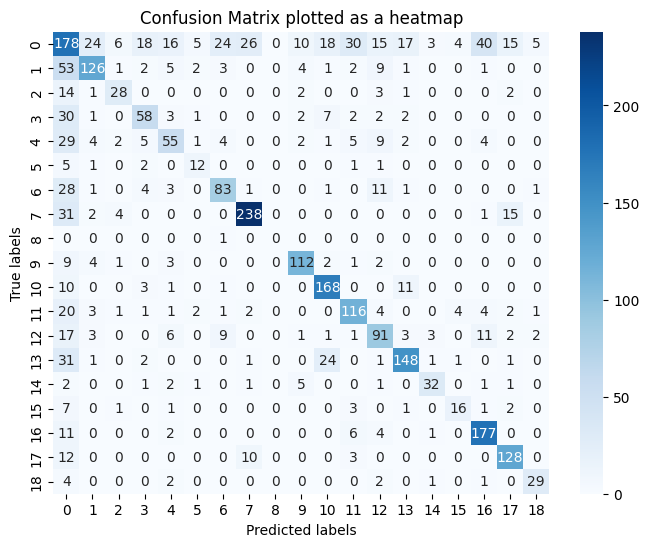

In [32]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns


index, true_labels = np.where(y_test_data == 1)
true_labels
y_test_gold = []

prediction_probas = model.predict([X_test_data, pos1_array_test, pos2_array_test,padded_sequences_test])

predictions = [np.argmax(pred) for pred in prediction_probas]

print(confusion_matrix(true_labels, predictions)) #from sklearn.metrics
print(classification_report(true_labels, predictions, digits=3))

cm = confusion_matrix(true_labels, predictions)
labels = [i for i in range(19)]
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix plotted as a heatmap')
plt.show()

## Saving the model and word index

In [33]:
from keras.models import load_model

# Assuming 'model' is your Keras model
model.save("my_model2.keras")

In [34]:
from gensim.models import KeyedVectors

# Create an empty KeyedVectors object
kv = KeyedVectors(vector_size=1)
a=0
# Iterate over the word index of the Tokenizer and add words to the KeyedVectors object
for word, index in tokenizer.word_index.items():
    kv.add_vector(word, index)
# Save the KeyedVectors object as .kv file
kv.save('tokenizer.kv')

/usr/local/lib/python3.10/dist-packages/gensim/models/keyedvectors.py:551: UserWarning: Adding single vectors to a KeyedVectors which grows by one each time can be costly. Consider adding in batches or preallocating to the required size.
  warnings.warn(


# Testing the model on user input

In [9]:
# UNCOMMENT and RUN THIS CELL IF YOU ARE USING GOOGLE COLAB
# mount drive and change directory
# from google.colab import drive
# drive.mount('/gdrive')
# %cd /gdrive
# %cd MyDrive/TextMining/

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive
/gdrive/MyDrive/TextMining


In [16]:
from keras.layers import Dense,Layer
from keras.models import load_model
import tensorflow as tf
import numpy as np



class AttentionLayer(Layer):
    def __init__(self, units):
        super(AttentionLayer, self).__init__()
        self.units = units
        # Define the weight matrices for attention mechanism
        self.W = Dense(units)
        self.V = Dense(1)

    def call(self, inputs):
        # Calculate attention scores
        score = tf.nn.tanh(self.W(inputs))
        # Apply softmax to obtain attention weights
        attention_weights = tf.nn.softmax(self.V(score), axis=1)
        # Apply attention weights to input sequences
        context_vector = attention_weights * inputs
        # Aggregate context vector across the sequence length
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector
import keras
keras.utils.get_custom_objects()["AttentionLayer"] = AttentionLayer

# loading our saved model. Please make sure to download the model using the link given in the README file.
loaded_model = load_model("my_model2.keras")


from gensim.models import KeyedVectors
from keras.preprocessing.text import Tokenizer


# Load the KeyedVectors object from the .kv file
kv = KeyedVectors.load('tokenizer.kv')

# Convert the loaded word index to tokenizer format
tokenizer= Tokenizer(num_words=25000, filters= '!"#$%&().:;-?@[]^_{|}~</>', lower=True)
tokenizer.word_index = {word: index+1 for index, word in enumerate(kv.index_to_key)}



In [24]:
from keras.preprocessing.sequence import pad_sequences
import spacy

max_len = 100
nlp = spacy.load("en_core_web_md")
def pos_to_numerical(sentences):
    pos_encoded = []
    for sentence in sentences:
        # Process the sentence using spaCy
        doc = nlp(sentence)
        # Extract POS tags and filter out unwanted tags
        pos_tags = [token.tag_ for token in doc if token.text not in ['<','>','/','"','.']]
        # Convert POS tags to numerical values (you may need to encode them differently based on your requirements)
        pos_encoded_sentence = [ord(tag[0]) for tag in pos_tags]  # Example encoding
        pos_encoded.append(pos_encoded_sentence)
    return pos_encoded

def calculate_relative_positions(sentence, e1_pos, e2_pos):
    words = sentence.split()  # Split the sentence into words
    pos1 = [(i - e1_pos + 100)/100 for i in range(len(words))]  # Calculate relative positions for e1
    pos2 = [(i - e2_pos + 100)/100 for i in range(len(words))]  # Calculate relative positions for e2
    return pos1, pos2

def find_entity_positions(sentence):
    e1_pos = -1
    e2_pos = -1
    words = sentence.split()  # Split the sentence into words
    for idx, word in enumerate(words):
        if "<e1>" in word and "</e1>" in word:
            e1_pos = idx
        elif "<e2>" in word and "</e2>" in word:
            e2_pos = idx
    pos1,pos2 = calculate_relative_positions(sentence,e1_pos,e2_pos)
    pos1 = pad_sequences([pos1], maxlen=max_len, dtype='float32')
    pos2=pad_sequences([pos2], maxlen=max_len, dtype='float32')
    return pos1, pos2

# Following is a mapping between relations and their corresponding ids
relation_ids = {
    "Other": 0,
    "Message-Topic(e1,e2)": 1,
    "Message-Topic(e2,e1)": 2,
    "Product-Producer(e1,e2)": 3,
    "Product-Producer(e2,e1)": 4,
    "Instrument-Agency(e1,e2)": 5,
    "Instrument-Agency(e2,e1)": 6,
    "Entity-Destination(e1,e2)": 7,
    "Entity-Destination(e2,e1)": 8,
    "Cause-Effect(e1,e2)": 9,
    "Cause-Effect(e2,e1)": 10,
    "Component-Whole(e1,e2)": 11,
    "Component-Whole(e2,e1)": 12,
    "Entity-Origin(e1,e2)": 13,
    "Entity-Origin(e2,e1)": 14,
    "Member-Collection(e1,e2)": 15,
    "Member-Collection(e2,e1)": 16,
    "Content-Container(e1,e2)": 17,
    "Content-Container(e2,e1)": 18,
}
ids_to_relations = {id: relation for id, relation in enumerate(relation_ids)}



def get_predictions(inputs):
    sequences = tokenizer.texts_to_sequences(inputs)
    index_input = pad_sequences(sequences, maxlen=max_len)

    #Finding relative distance for every sentence and making a numpy array
    pos1_list = []
    pos2_list = []

    for sentence in inputs:
        e1_pos, e2_pos = find_entity_positions(sentence)
        pos1_list.append(e1_pos)
        pos2_list.append(e2_pos)

    pos1_array = np.array(pos1_list)
    pos2_array = np.array(pos2_list)
    pos1_array_input = pos1_array.reshape(pos1_array.shape[0], pos1_array.shape[2])
    pos2_array_input = pos2_array.reshape(pos2_array.shape[0], pos2_array.shape[2])
    # Convert 'sentence' column to numerical POS tags
    numerical_pos_tags = pos_to_numerical(inputs)

    # Pad sequences to a fixed length
    padded_sequences_input = pad_sequences(numerical_pos_tags, maxlen=max_len)

    prediction_probas = loaded_model.predict([index_input, pos1_array_input, pos2_array_input,padded_sequences_input])
    predictions = [np.argmax(pred) for pred in prediction_probas]

    predictions = [ids_to_relations[id] for id in predictions]

    print(predictions)


In [25]:
# You can provide inputs in the form of a list of sentences and call predict_with_loaded_model function.
# The model will return the prediction for each sentence in the form of a list.
# Make sure to put <e1> and <e2> tags around the entities.
inputs = ["Their <e1>composer</e1> has sunk into <e2>oblivion</e2>.",
          "The fifty <e1>essays</e1> collected in this <e2>volume</e2> testify to most of the prominent themes from Professor Quispel's scholarly career.",
          "he Pulitzer Committee issues an official <e1>citation</e1> explaining the <e2>reasons</e2> for the award."]

get_predictions(inputs)


1/1 [==============================] - 0s 290ms/step
['Other', 'Member-Collection(e1,e2)', 'Message-Topic(e1,e2)']
